In [1]:
import os

import numpy as np
import pickle
import time
import pandas as pd

from tqdm.auto import tqdm

import INN
import torch
import torch.nn.functional as F
from torch.optim import Adam
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
retrain = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


# Data

In [4]:
with open('../../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (2488918, 33)
y_train.shape = (2488918, 2)


In [5]:
INN_parameters = {
    'in_features': X_train.shape[1],
    'out_features': y_train.shape[1],
    'device': device
}

loss_weights = {
    'bce_factor': 10,
    'dvg_factor': 1,
    'logdet_factor': 1,
    'rcst_factor': 1
}

lr = 5e-4

In [6]:
n_epochs = 32
batch_size = 512

In [7]:
hyperparameter_search_space_boundaries = {
    'n_blocks': [1, 12],
    'n_coupling_network_hidden_layers': [1, 5],
    'n_coupling_network_hidden_nodes': [4, 512 + 256],
}

In [8]:
def scale_hyperparameters(hyperparameters):
    return np.array([h * (boundaries[1] - boundaries[0]) + boundaries[0] for h, boundaries in zip(hyperparameters, hyperparameter_search_space_boundaries.values())])

## Helper Functions

In [9]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
    return total_params

## GP-Prediction

In [10]:
print(f'Loading Results ...')
with open(f'../../hyperparameter_results/INN.pt', 'rb') as file:
    Q, E = pickle.load(file)
print(f'Loaded Results')

GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(3))
GP.optimize(messages=False);

Loading Results ...
Loaded Results


In [11]:
Q_scaled = np.round([scale_hyperparameters(q) for q in Q]).astype(int)

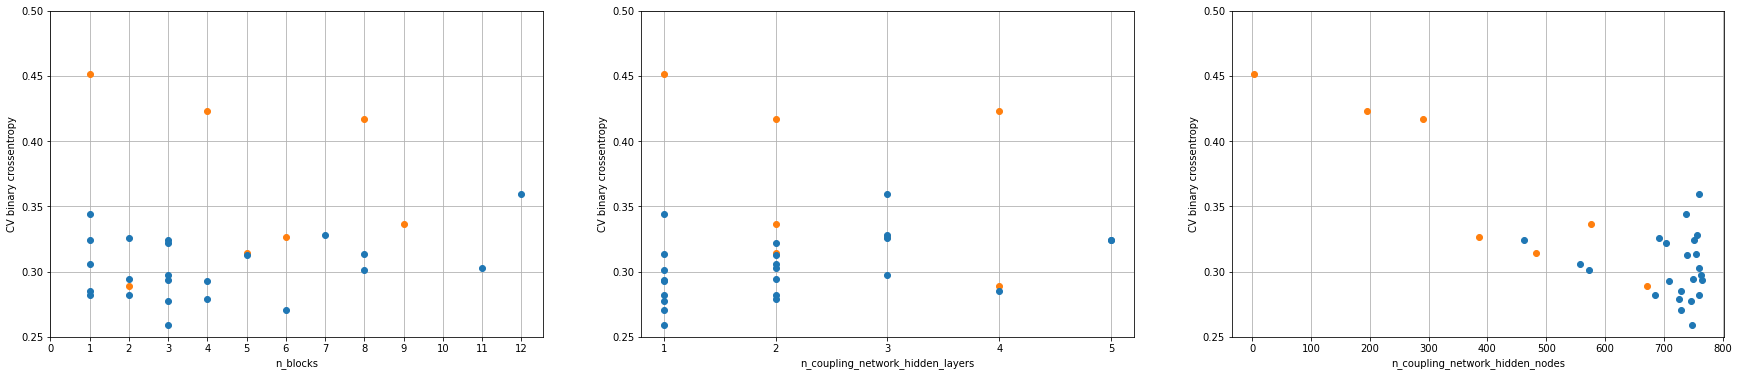

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

for i, key in enumerate(hyperparameter_search_space_boundaries.keys()):
    axes[i].scatter(Q_scaled[:8, i], E[:8], zorder=3, color='tab:orange', label='initial GP')
    axes[i].scatter(Q_scaled[8:, i], E[8:], zorder=3, color='tab:blue', label='trained GP')
    axes[i].set_xlabel(key); axes[i].set_ylabel('CV binary crossentropy')
    axes[i].set_ylim(0.25, 0.5)
    axes[i].grid(zorder=1)

axes[0].set_xticks(range(13));
axes[1].set_xticks(range(1, 6));

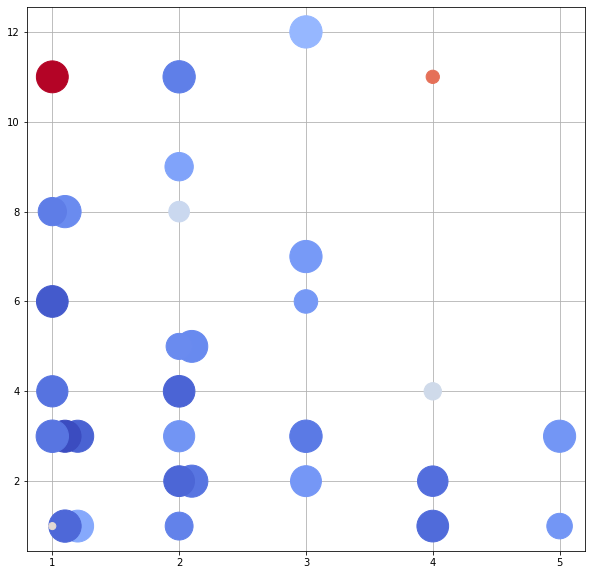

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

y, x, z = Q_scaled.T
e = E[:, 0]

counts = np.zeros((np.max(x)+1, np.max(y)+1))
offset = np.zeros(len(Q))

for i, (x_value, y_value) in enumerate(zip(x, y)):
    counts[x_value, y_value] += 1
    offset[i] += counts[x_value, y_value] - 1


ax.scatter(x[::-1] + offset[::-1]*0.1, y[::-1], s=50 + 1000*(z[::-1] - np.min(z))/(np.max(z) - np.min(z)), color=plt.get_cmap('coolwarm')((E[::-1] - np.min(E))/(np.max(E) - np.min(E))), zorder=3)
ax.set_xticks(range(1, 6)); ax.grid(zorder=1)

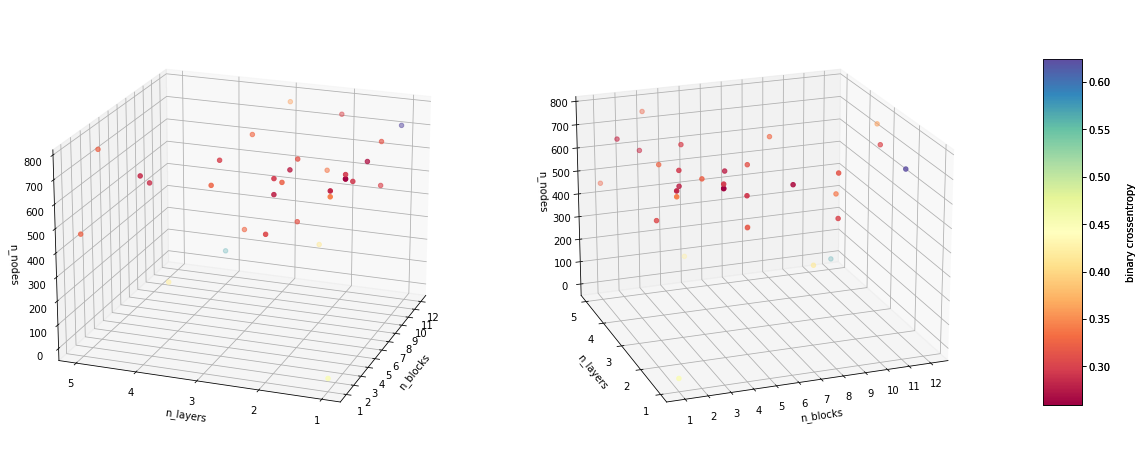

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection':'3d'})
fig.tight_layout(w_pad=10)
fig.subplots_adjust(right=0.75)

offset = 180
for i, angle in enumerate([20+offset, 90-20+offset]):
    x, y, z = Q_scaled.T
    c = E[:, 0]
    
    axes[i].set_xlabel(r'n_blocks'); axes[i].set_ylabel(r'n_layers'); axes[i].set_zlabel(r'n_nodes')
    axes[i].set_xticks(range(13)); axes[i].set_yticks(range(1, 6));
    axes[i].view_init(elev=20., azim=angle)

    img = axes[i].scatter(x, y, z, c=c, cmap=plt.get_cmap('Spectral'))
    colorbar_ax = fig.add_axes([0.8, 0.2, 0.03, 0.6])
    fig.colorbar(img, cax=colorbar_ax, label='\nbinary crossentropy')

## Find 'Best' Hyperparameter

In [15]:
def GP_log_loss_upper_confidence_bound(n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes, gp):
    mean, var = gp.predict_noiseless(np.array([[n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes]]))
    return mean + np.sqrt(var)

In [16]:
hyperparameter_best_upper_confidence_bound = opt.minimize(
    lambda **kwargs: GP_log_loss_upper_confidence_bound(gp=GP, **kwargs),
    **{k: [0, 1] for k in hyperparameter_search_space_boundaries.keys()}
)[0]

hyperparameter_best_upper_confidence_bound_scaled = scale_hyperparameters(hyperparameter_best_upper_confidence_bound.values()).round().astype(int)

In [17]:
best_sampled_hyperparameters = scale_hyperparameters(Q[np.argmin(E)]).round().astype(int)

In [18]:
print(f'{best_sampled_hyperparameters=}')

best_sampled_hyperparameters=array([  3,   1, 748])


# Final Training

In [19]:
if retrain:
    for i in range(5):
        # scale features
        sc_X_train = StandardScaler()
        X_train_scaled = sc_X_train.fit_transform(X_train)

        #create classifier
        inn = INN.INN(**INN_parameters, 
            n_blocks=best_sampled_hyperparameters[0], 
            coupling_network_layers=[best_sampled_hyperparameters[2]] * best_sampled_hyperparameters[1]
        )
        inn.train()

        X_train_scaled_cuda = torch.Tensor(X_train_scaled).to(device)
        y_train_cuda = torch.Tensor(y_train).to(device)

        # fit
        loss_history = inn.fit(X_train_scaled_cuda, y_train_cuda, 
            n_epochs=n_epochs,
            batch_size=batch_size,
            optimizer=Adam(inn.parameters(), lr=lr), 
            loss_weights=loss_weights,
            verbose=1,
        );

        with open(f'../../evaluation_results/models/INN_{i}.pt', 'wb') as file:
            pickle.dump(inn.to('cpu'), file)

        with open(f'../../evaluation_results/loss_history/INN{i}.pt', 'wb') as file:
            pickle.dump(loss_history, file)

        del inn, X_train_scaled_cuda, y_train_cuda

else:
    if os.path.exists('../../evaluation_results/models/INN.pt'):
        with open('../../evaluation_results/models/INN.pt', 'rb') as file:
            inn = pickle.load(file)
    if os.path.exists('../../evaluation_results/loss_history/INN.pt'):
        with open('../../evaluation_results/loss_history/INN.pt', 'rb') as file:
            loss_history = pickle.load(file)

Epoch 31: 100%|██████████| 9722/9722 [01:40<00:00, 96.63it/s, batch=9721/9722, weighted_loss=-73.306, bce=+0.119, dvg=+9.689, rcst=+0.435, logdet=-84.619]


In [23]:
bces = []

for i in range(5):
    with open(f'../../evaluation_results/models/INN_{i}.pt', 'rb') as file:
        inn = pickle.load(file)
    
    inn.eval()
    inn.to(device)

    evaluation_results = {}

    with open('../../data/data_test.pt', 'rb') as file:
        X_test, y_test = pickle.load(file)
    X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

    n_batches = len(X_test) // batch_size
    y_proba_pred = np.empty((len(X_test), 2))
    for i_batch in range(n_batches + 1):
        y_proba_pred[i_batch * batch_size: (i_batch+1) * batch_size] = inn.forward(X_test_scaled[i_batch * batch_size: (i_batch+1) * batch_size])[0].detach().cpu().numpy()

    bces.append({})
    for j, y_label in enumerate(['hosp', 'death']):
        # print(f'--- {y_label} ---')
        bces[i][y_label] = log_loss(y_test[:, j], y_proba_pred[:, j])
    
    print(i, np.mean([v for v in bces[i].values()]))

0 0.1554235065339947
1 0.1387363376215738
2 0.13111855518752896
3 0.13190129348865304
4 0.13306221609716395


In [ ]:
# 2

# Evaluation on Test Set

In [29]:
# IMPORTANT: Disable Dropout
with open('../../evaluation_results/models/INN_2.pt', 'rb') as file:
    inn = pickle.load(file)

with open('../../evaluation_results/loss_history/INN2.pt', 'rb') as file:
    loss_history = pickle.load(file)

inn.eval();
inn.to(device);

In [30]:
with open('../../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

X_test.shape = (622230, 33)
y_test.shape = (622230, 2)


In [31]:
evaluation_results = {}

n_batches = len(X_test) // batch_size
y_proba_pred = np.empty((0, 2))
z_pred = np.empty((0, 31))
for i_batch in tqdm(range(n_batches + 1)):
    y_proba_pred_new, z_pred_new = inn.forward(X_test_scaled[i_batch * batch_size: (i_batch+1) * batch_size])
    y_proba_pred = np.concatenate([y_proba_pred, y_proba_pred_new.detach().cpu().numpy()], axis=0)
    z_pred = np.concatenate([z_pred, z_pred_new.detach().cpu().numpy()], axis=0)

100%|██████████| 1216/1216 [00:18<00:00, 67.35it/s]


In [34]:
n_batches = len(X_train) // batch_size
y_train_proba_pred = np.empty((len(X_train), 2))
z_train_pred = np.empty((len(X_train), 31))

X_train_scaled_cuda = torch.Tensor(X_train_scaled).to(device)

for i_batch in tqdm(range(n_batches + 1)):
    y_train_proba_pred_new, z_train_pred_new = inn.forward(X_train_scaled_cuda[i_batch * batch_size: (i_batch+1) * batch_size])
    y_train_proba_pred[i_batch * batch_size: (i_batch+1) * batch_size] = y_train_proba_pred_new.detach().cpu().numpy()
    z_train_pred[i_batch * batch_size: (i_batch+1) * batch_size] = z_train_pred_new.detach().cpu().numpy()

del X_train_scaled_cuda

100%|██████████| 4862/4862 [00:07<00:00, 609.32it/s]


# Convergence

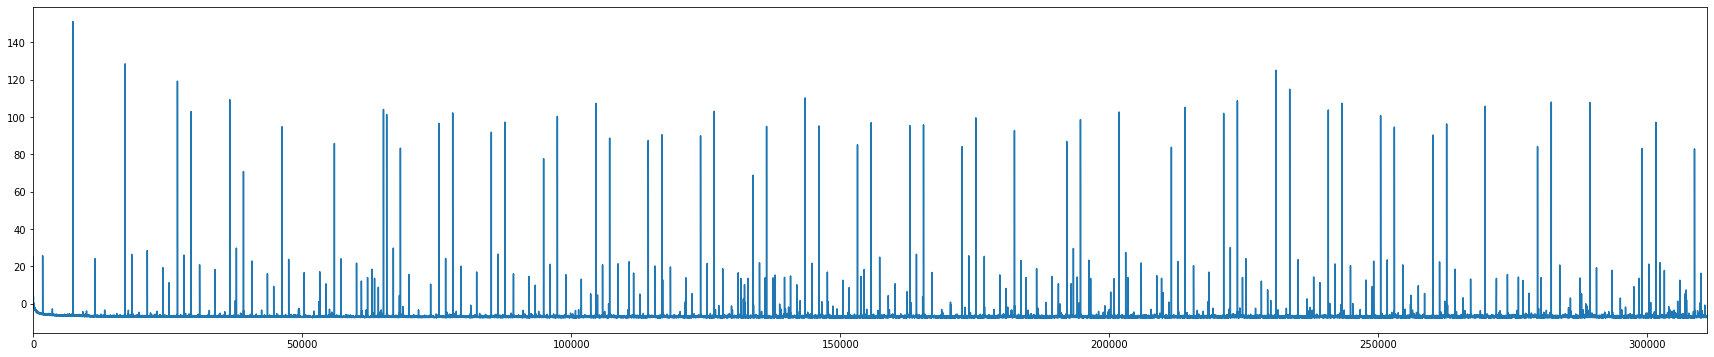

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(30, 6))

ax.plot(np.array(loss_history['bce'])/10);
ax.set_xlim(0, len(loss_history['bce']));

# Latent Space

## Distribution

100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


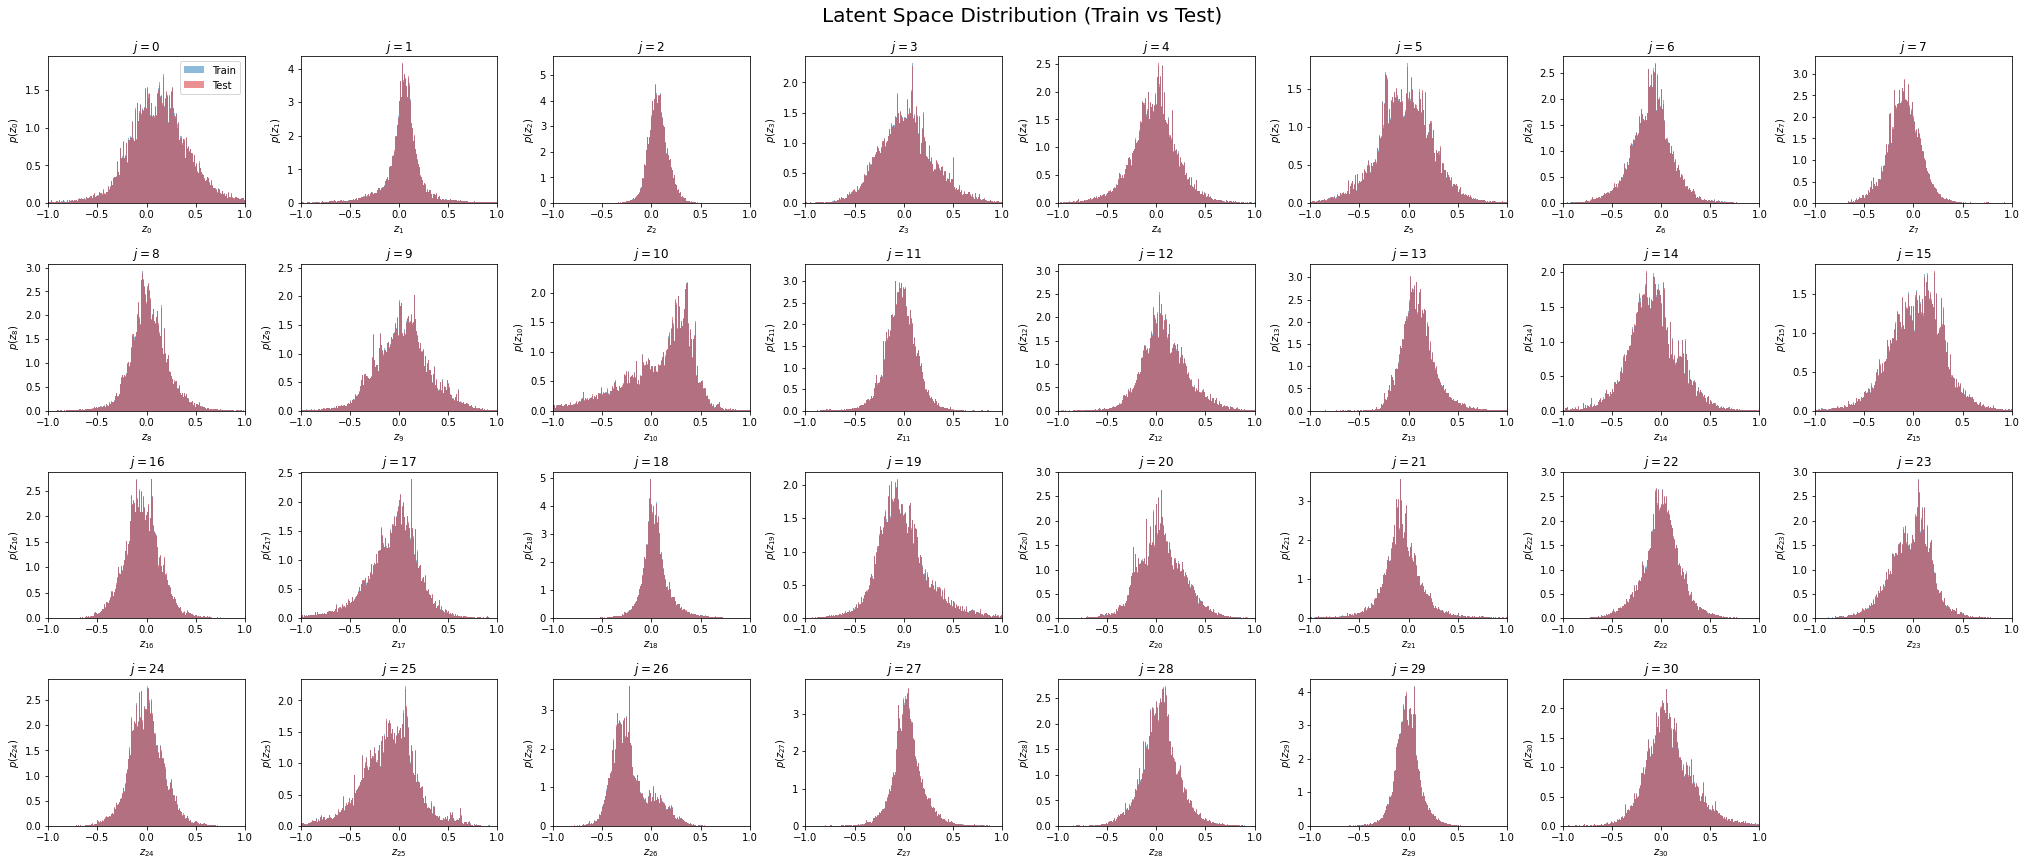

In [36]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(28, 12))
fig.suptitle('Latent Space Distribution (Train vs Test)\n', size=20)
fig.tight_layout(h_pad=4, w_pad=2.5)
bins = np.linspace(-1, 1, 256)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_train_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Train', color='tab:blue')
        axes[i_row][i_col].hist(z_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Test', color='tab:red')
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-1, 1); 
        if i_latent == 0: axes[i_row][i_col].legend();

## Indepencence

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


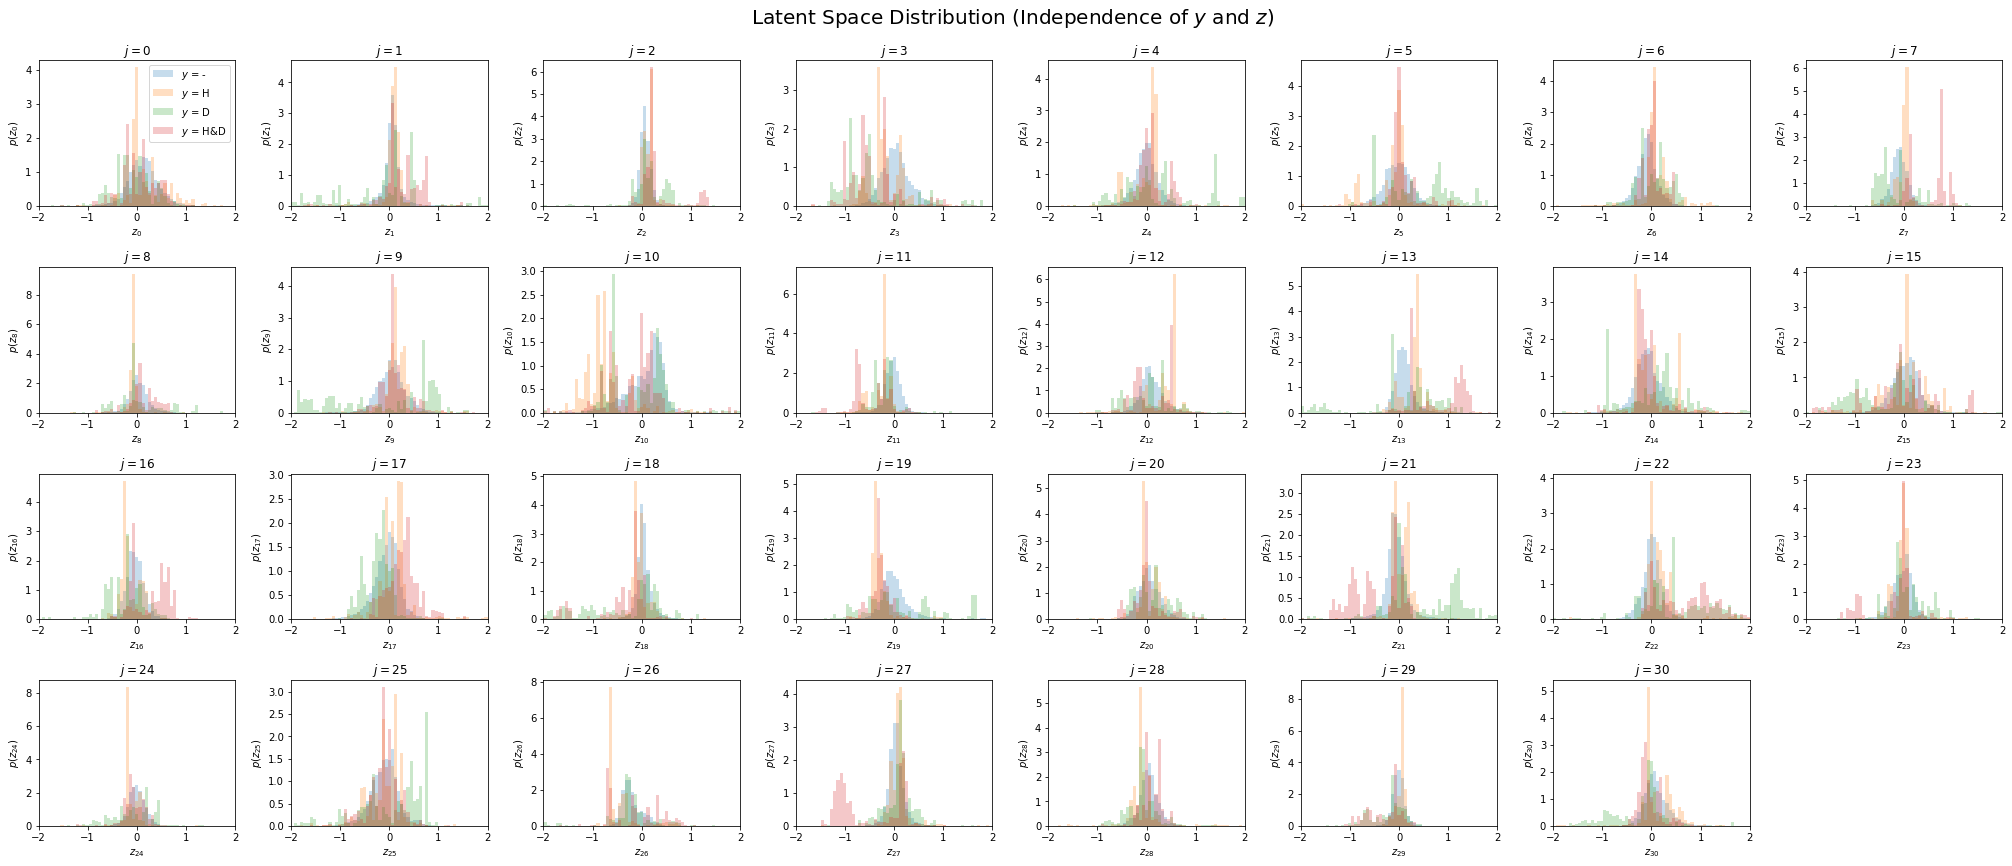

In [37]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(28, 12))
fig.suptitle('Latent Space Distribution (Independence of $y$ and $z$)\n', size=20)
fig.tight_layout(h_pad=4, w_pad=2.5)
bins = np.linspace(-2, 2, 64)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] < 0.5, y_proba_pred[:, 1] < 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = -',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] >= 0.5, y_proba_pred[:, 1] < 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = H',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] < 0.5, y_proba_pred[:, 1] >= 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = D',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] >= 0.5, y_proba_pred[:, 1] >= 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = H&D',)
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-2, 2); 
        if i_latent == 0: axes[i_row][i_col].legend();

In [38]:
keys = ['sex_female','age_0','age_18','age_50','age_65','race_native','race_asian','race_black','race_other','race_native_pacific','race_white','ethnicity_hispanic','case_onset_interval','symptom_status','used_bed_ratio','used_icu_ratio','rural-urban_Continuum Code_2013','urban_influence_code_2013','economic_typology_2015','pop_estimate_2019','less_hs_pct','hs_only_pct','some_college_pct','bachelor_higher_pct','unempl_rate','med_hh_income_19','med_hh_income_pct_state_total_19','poverty_pct_19', 'democrat_20_ratio', 'republican_20_ratio','green_20_ratio','libertarian_20_ratio','other_20_ratio']

def prettyX(X, index=None):
    return pd.DataFrame(X, columns=keys, index=index)

In [39]:
y_zeros = torch.zeros((1, 2)).to(device)
y_h = torch.Tensor([[1, 0]]).to(device)
y_d = torch.Tensor([[0, 1]]).to(device)
y_hd = torch.Tensor([[1, 1]]).to(device)
z_zeros = torch.zeros((1, 31)).to(device)

## Reconstruction: Latent Zeros

In [40]:
x_zeros_pred = inn.inverse(y_zeros, z_zeros).detach().cpu().numpy()
x_h_pred = inn.inverse(y_h, z_zeros).detach().cpu().numpy()
x_d_pred = inn.inverse(y_d, z_zeros).detach().cpu().numpy()
x_hd_pred = inn.inverse(y_hd, z_zeros).detach().cpu().numpy()

In [41]:
x_all = np.concatenate([x_zeros_pred, x_h_pred, x_d_pred, x_hd_pred], axis=0)

In [42]:
prettyX(sc_X_train.inverse_transform(x_all), index=['-', 'H', 'D', 'HD']).T

,-,H,D,HD
sex_female,5.324534e-01,5.133781e-01,5.331224e-01,5.147659e-01
age_0,1.004237e-01,1.047878e-01,1.009845e-01,1.055297e-01
age_18,6.247787e-01,6.045091e-01,6.233732e-01,6.029481e-01
age_50,1.938360e-01,1.964975e-01,1.958537e-01,1.989489e-01
age_65,8.957324e-02,9.036658e-02,8.954557e-02,9.029997e-02
race_native,1.761115e-02,1.757417e-02,1.783102e-02,1.774055e-02
race_asian,-1.066931e-02,-1.804333e-02,-2.502738e-03,-1.012345e-02
race_black,7.114063e-02,7.365899e-02,7.201752e-02,7.485631e-02
race_other,1.334761e-02,2.959949e-02,1.446576e-02,3.101957e-02
race_native_pacific,1.009037e-02,5.949222e-03,9.985942e-03,5.838988e-03


## Reconstruction: Encodings

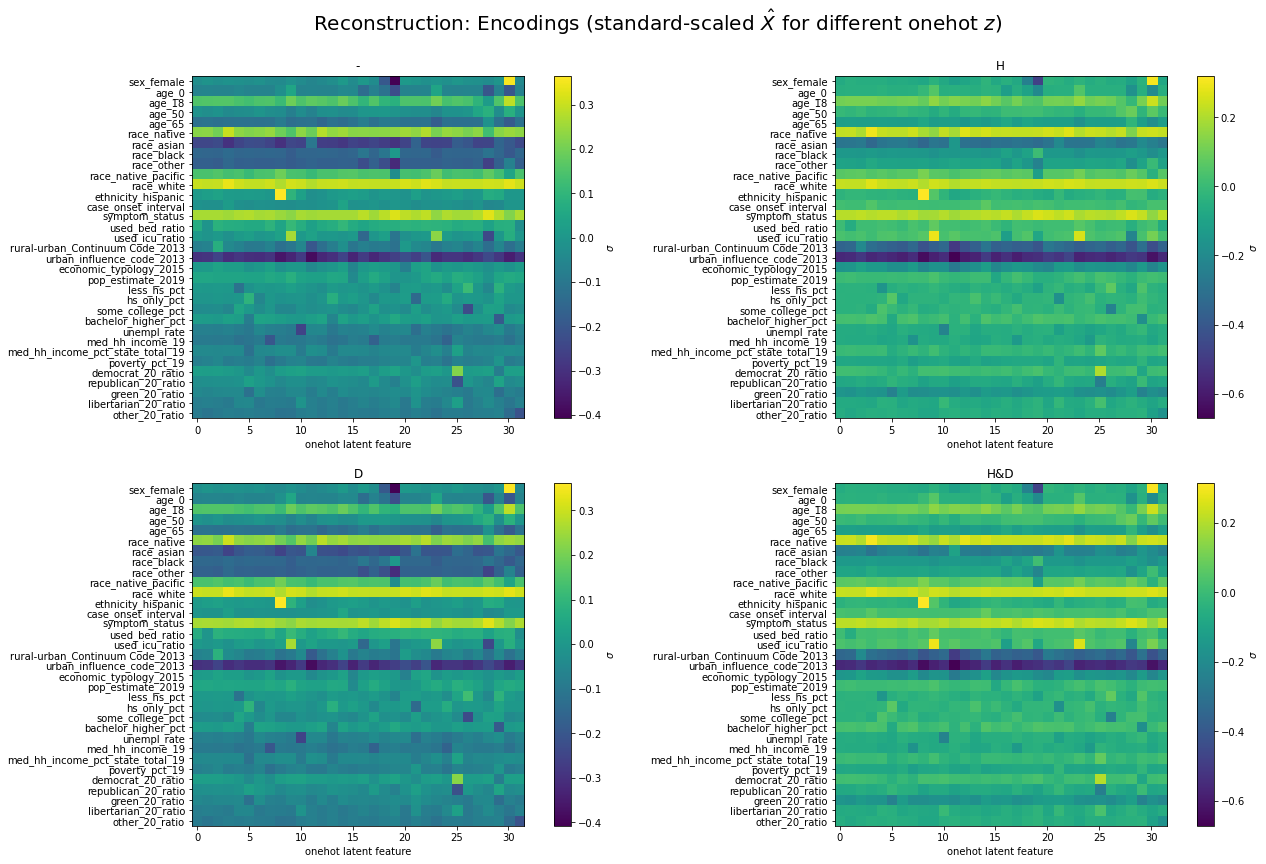

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(h_pad=5)
fig.suptitle(r'Reconstruction: Encodings (standard-scaled $\hat X$ for different onehot $z$)', size=20);
fig.subplots_adjust(top=0.9)

for i, y_combination, y_combination_name in zip(range(4), [[0,0], [1,0], [0,1], [1,1]], ['-', 'H', 'D', 'H&D']):
    y_zeros = torch.Tensor([y_combination]*32).to(device)
    z_onehot = torch.cat([torch.zeros((1, 31)), F.one_hot(torch.arange(0, 31))], dim=0).to(device)
    x_onehot = inn.inverse(y_zeros, z_onehot)

    img = axes[i//2][i%2].imshow(x_onehot.detach().cpu().T);
    fig.colorbar(img, ax=axes[i//2][i%2], label='$\sigma$');
    axes[i//2][i%2].set_xlabel('onehot latent feature'); axes[i//2][i%2].set_title(y_combination_name)
    axes[i//2][i%2].set_yticks(np.arange(len(keys)))
    axes[i//2][i%2].set_yticklabels(keys);

In [44]:
# x_self = {
#     'sex_female': 0,
#     'age_0': 0,
#     'age_18': 1,
#     'age_50': 0,
#     'age_65': 0,
#     'race_native': 0,
#     'race_asian': 0,
#     'race_black': 0,
#     'race_other': 0,
#     'race_native_pacific': 0,
#     'race_white': 1,
#     'ethnicity_hispanic': 0,
#     'case_onset_interval': 0,
#     'symptom_status': 1,
#     'used_bed_ratio': 0.763, #https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Gesundheit/Krankenhaeuser/Tabellen/eckzahlen-krankenhaeuser.html
#     'used_icu_ratio': 2237/2723, #https://www.intensivbetten-deutschland.de/#baden-wuerttemberg
#     'rural-urban_Continuum Code_2013': ,
#     'urban_influence_code_2013': ,
#     'economic_typology_2015': ,
#     'pop_estimate_2019': 548355, #https://de.statista.com/statistik/daten/studie/1172600/umfrage/entwicklung-der-gesamtbevoelkerung-im-rhein-neckar-kreis/
#     'less_hs_pct': (0.035 + 0.286 + 0.235 + 0.04), #https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bildung-Forschung-Kultur/Bildungsstand/Tabellen/bildungsabschluss.html;jsessionid=5F506FE286D82795D2AD411A8EB8435D.live731
#     'hs_only_pct': 25.5,
#     'some_college_pct': ,
#     'bachelor_higher_pct': (0.026 + 0.018 + 0.129 + 0.012),
#     'unempl_rate' 0.04, #https://www.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/arbeitsmarkt-im-land-lebt-weiter-auf/
#     'med_hh_income_19': 25_278, #https://de.wikipedia.org/wiki/Liste_der_Landkreise_nach_Einkommen
#     'med_hh_income_pct_state_total_19': ,
#     'poverty_pct_19': 0.119 #https://paritaet-bw.de/presseportal/pressemitteilungen/armut-baden-wuerttemberg-bei-119-prozent-der-paritaetische-baden-wuerttemberg-fordert-vom-land-sich-weiterhin-gegen-kinderarmut-stark-zu-machen
# }

In [45]:
# IDEA: personal data -> latent representation -> set y = 0 -> inverse -> observe what changed

In [46]:
x_dead = X_test_scaled[y_test[:, 1] == 1][0].reshape(1, -1)

y_dead, z_dead = inn.forward(x_dead)
y_alive = torch.Tensor([[0, 0]]).to(device)

x_reconstructed = inn.inverse(y_dead, z_dead).detach().cpu().numpy()
x_alive = inn.inverse(y_alive, z_dead).detach().cpu().numpy()

x_combined = np.concatenate([x_dead.detach().cpu().numpy(), x_reconstructed, x_alive], axis=0)

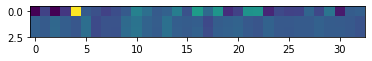

In [47]:
plt.imshow(x_combined)

In [48]:
prettyX(sc_X_train.inverse_transform(x_combined), index=['Dead', 'Reconstructed Dead', 'Reconstructed Alive']).T

,Dead,Reconstructed Dead,Reconstructed Alive
sex_female,1.604905e-08,5.596071e-01,5.611461e-01
age_0,2.591115e-09,1.069824e-01,1.062409e-01
age_18,-1.707345e-08,6.174031e-01,6.205099e-01
age_50,-6.559074e-09,1.978603e-01,1.972614e-01
age_65,1.000000e+00,9.441554e-02,9.432578e-02
race_native,-9.632341e-11,1.756118e-02,1.747282e-02
race_asian,8.787066e-10,-1.545244e-02,-1.487701e-02
race_black,-1.711044e-09,6.721665e-02,6.667620e-02
race_other,-1.114526e-09,1.547974e-02,1.264414e-02
race_native_pacific,-1.760619e-10,1.157031e-02,1.223069e-02


In [70]:
evaluation_results = {'hosp': [], 'death': []}

for j in range(5):

    with open(f'../../evaluation_results/models/INN_{j}.pt', 'rb') as file:
        inn = pickle.load(file).to(device)

    n_batches = len(X_test) // batch_size
    y_proba_pred = np.empty((len(X_test), 2))
    for i_batch in tqdm(range(n_batches + 1)):
        y_proba_pred[i_batch * batch_size: (i_batch+1) * batch_size] = inn.forward(X_test_scaled[i_batch * batch_size: (i_batch+1) * batch_size])[0].detach().cpu().numpy()

    for i, y_label in enumerate(['hosp', 'death']):
        print(f'--- {y_label} ---')
        evaluation_results[y_label].append(np.concatenate([1 - y_proba_pred[:, i].reshape(-1, 1), y_proba_pred[:, i].reshape(-1, 1)], axis=1))

        print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], evaluation_results[y_label][-1][:, 1]), 4)}')
        print(f'brier loss: {brier_score_loss(y_test[:, i], evaluation_results[y_label][-1][:, 1]).round(4)}')
        print(f'accuracy: {accuracy_score(y_test[:, i], evaluation_results[y_label][-1][:, 1].round()).round(4)}')
        print('confusion matrix:')
        print(confusion_matrix(y_test[:, i], (evaluation_results[y_label][-1][:, 1] > 0.5).astype(int)))
        print()
        time.sleep(0.5)

100%|██████████| 1216/1216 [00:02<00:00, 562.16it/s]


--- hosp ---
binary cross-entropy: 0.2741
brier loss: 0.0567
accuracy: 0.9333
confusion matrix:
[[577786   1861]
 [ 39662   2921]]

--- death ---
binary cross-entropy: 0.0626
brier loss: 0.0124
accuracy: 0.9862
confusion matrix:
[[612040   1938]
 [  6665   1587]]



100%|██████████| 1216/1216 [00:02<00:00, 540.42it/s]


--- hosp ---
binary cross-entropy: 0.3
brier loss: 0.0699
accuracy: 0.9167
confusion matrix:
[[564899  14748]
 [ 37062   5521]]

--- death ---
binary cross-entropy: 0.0507
brier loss: 0.011
accuracy: 0.9881
confusion matrix:
[[613213    765]
 [  6666   1586]]



100%|██████████| 1216/1216 [00:01<00:00, 613.22it/s]


--- hosp ---
binary cross-entropy: 0.2348
brier loss: 0.0597
accuracy: 0.9306
confusion matrix:
[[576360   3287]
 [ 39905   2678]]

--- death ---
binary cross-entropy: 0.0521
brier loss: 0.0116
accuracy: 0.987
confusion matrix:
[[612513   1465]
 [  6619   1633]]



100%|██████████| 1216/1216 [00:01<00:00, 651.82it/s]


--- hosp ---
binary cross-entropy: 0.2422
brier loss: 0.0612
accuracy: 0.9271
confusion matrix:
[[572086   7561]
 [ 37770   4813]]

--- death ---
binary cross-entropy: 0.0658
brier loss: 0.0134
accuracy: 0.9844
confusion matrix:
[[610789   3189]
 [  6514   1738]]



100%|██████████| 1216/1216 [00:01<00:00, 641.22it/s]


--- hosp ---
binary cross-entropy: 0.2166
brier loss: 0.0575
accuracy: 0.9313
confusion matrix:
[[577643   2004]
 [ 40735   1848]]

--- death ---
binary cross-entropy: 0.0669
brier loss: 0.0125
accuracy: 0.9858
confusion matrix:
[[611772   2206]
 [  6659   1593]]



In [71]:
with open('../../evaluation_results/predictions/INN.pt', 'wb') as file:
    pickle.dump(evaluation_results, file)